# Finding Defective SenseBox Sensors and Data Anomalies on OpenSenseMap
John Murzaku

2019-02-07

# Introduction
This document shows how to find and determine influential data points in openSenseMap (https://opensensemap.org)  using R and opensensmapr package (https://github.com/sensebox/opensensmapR). From this it is possible to determine defective boxes and either flag them as defective on openSenseMap or notify the owners that there is a problem with their box. This analysis can also determine potential anomalies in the data. 
## Analysis
The analysis takes a look at temperature data from sensors on openSenseMap and then determines influential data points using cook's distance. From this, finding defective boxes or data anomalies is also possible. 
## What is cook's distance?
Cook's distance is a measure that detects observations that strongly influence fitted values of a model. It is used to discover influential data points in a data set. (for more on cook's distance see https://en.wikipedia.org/wiki/Cook%27s_distance)

## Analyzing the data set
### Loading required libraries

In [17]:
library(lubridate)
library(dplyr)
library(units)
library(sf)
library(opensensmapr)
library(ggplot2)
library(lindia)

We will also be using plot with some dependencies to initially visualize our data. So also load:

In [18]:
if (!require('maps'))     install.packages('maps')
if (!require('maptools')) install.packages('maptools')
if (!require('rgeos'))    install.packages('rgeos')

### Get all the openSenseMap boxes containing outdoor temperature data

We want to get all the sensors that have outdoor exposure and that collect temperature as a phenomenon.

In [19]:
all_sensors = osem_boxes()
temp_sensors = osem_boxes(
  exposure = 'outdoor',
  date = Sys.time(),
  phenomenon = 'Temperatur'
)

### The distribution of boxes with temperature sensors

In [20]:
summary(temp_sensors)

boxes total: 1864

boxes by exposure:
outdoor 
   1864 

boxes by model:
                  custom          hackair_home_v2             homeEthernet 
                      56                        1                       10 
   homeEthernetFeinstaub  homeV2EthernetFeinstaub               homeV2Lora 
                      28                        2                        7 
              homeV2Wifi      homeV2WifiFeinstaub                 homeWifi 
                       8                       85                       33 
       homeWifiFeinstaub luftdaten_pms1003_bme280 luftdaten_pms3003_bme280 
                      59                        1                        1 
luftdaten_pms5003_bme280 luftdaten_pms7003_bme280         luftdaten_sds011 
                       6                        8                       13 
 luftdaten_sds011_bme280  luftdaten_sds011_bmp180   luftdaten_sds011_dht11 
                     429                       27                       63 
  luftdaten_sds

### A visual of the geographic distribution boxes with temperature sensors 

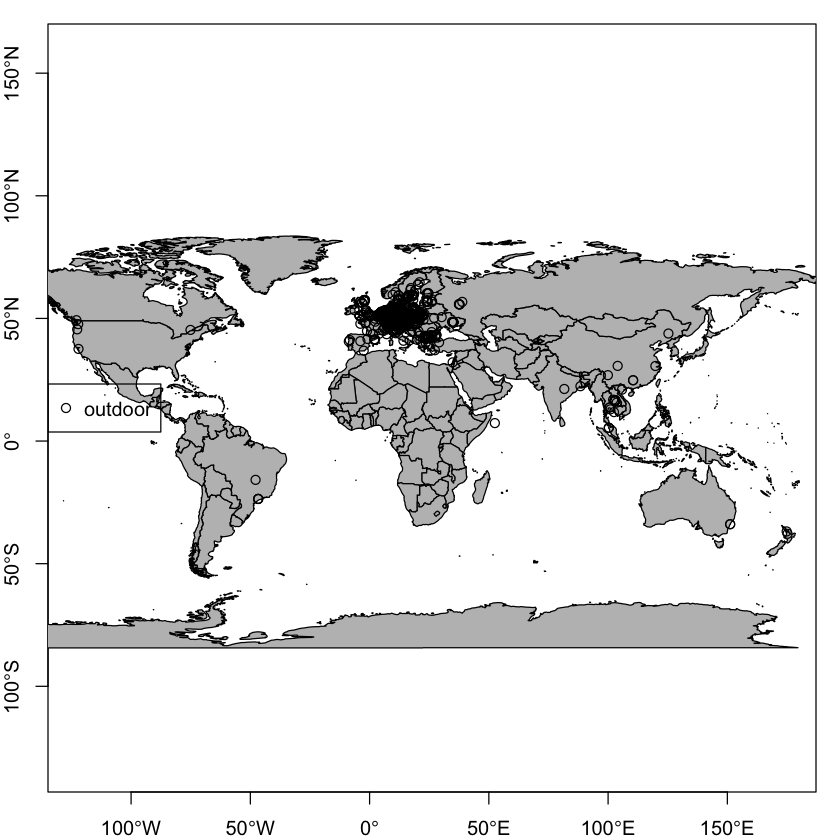

In [21]:
plot(temp_sensors)

### Analyzing Temperature Data of a city using a bounding box
Here I will build a 50 km bounding box around the city of Münster. It is better to contain all the data points in a radius so it is easier to find the defective boxes. 

In [22]:
#Construct a bounding box 50 kilometers around Münster
munster = st_point(c(7.6261, 51.9607)) %>% #Longitude and lattitude of city
  st_sfc(crs = 4326) %>%
  st_transform(3857) %>% #Allow setting a buffer in meters
  st_buffer(set_units(50, km)) %>% #Specify the radius of the bounding box
  st_transform(4326) %>% #The opensensemap expects WGS 84 format
  st_bbox() #Create the bounding box

Now collect the temperature values of Münster and store it inside a data frame. This data frame will be called temp.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.00   21.12   23.20   23.87   25.40   41.04 

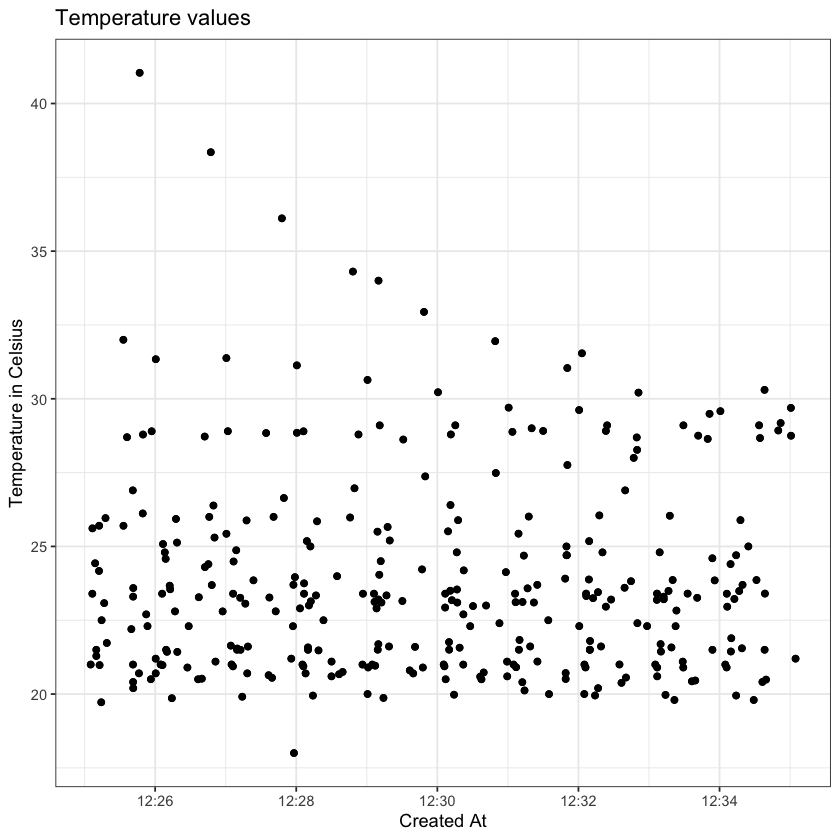

In [23]:
temp <- osem_measurements(
    munster,
    phenomenon = 'Temperatur', #Temperature phenomen of box (Temperatur is German)
    from = now() - minutes(10), #Münster tempereature from 10 minutes ago to now
    to = now()
)

summary(temp$value) #Return a summary of the data

#Use ggplot2 library to plot data
ggplot(temp, aes(x=createdAt, y=value)) + 
    labs(x="Created At", y="Temperature in Celsius") + 
    geom_point() + 
    geom_jitter(width = 0.15) +
    ggtitle('Temperature values') +
    theme_bw() 



There appears to be some very high outliers right from the start with some extreme temperature values.

### Further analysis of the temperature values
I will use a linear model to extract cook's distances from. With the cook's distance it will be possible to find the anomalies.

In [24]:
#First create a linear model of the data. This model is a time series of temperature.
temp_model <- lm(value ~ createdAt, data = temp, na.action = na.omit)

#Next find the cook's distance of the model
cooksd <- cooks.distance(temp_model)

### Cook's distance of the temperature model

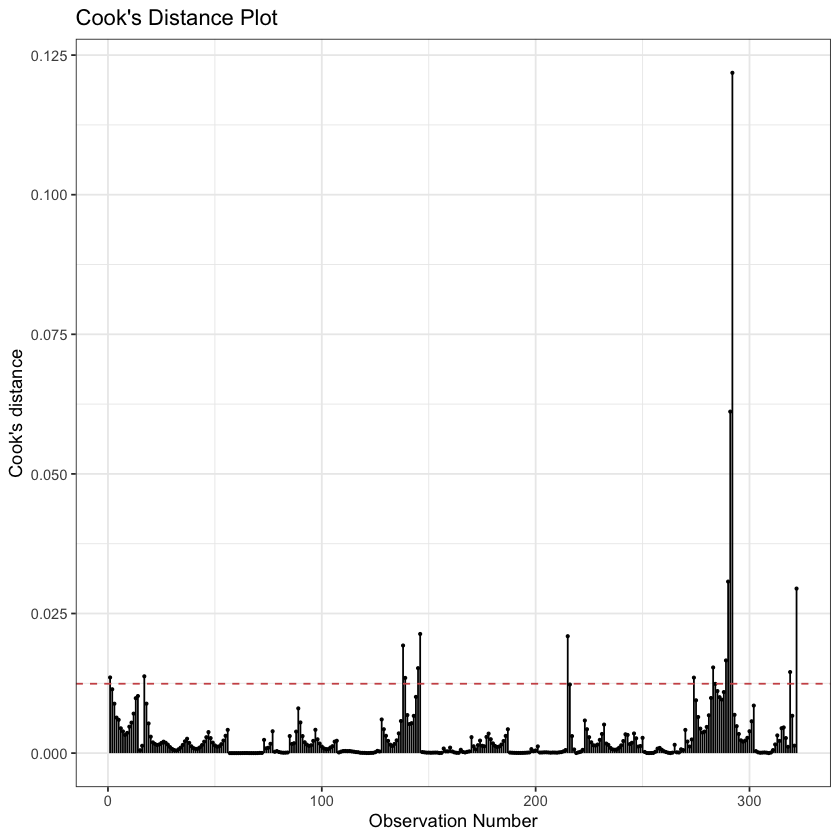

In [25]:
gg_cooksd(temp_model, label= FALSE) + theme_bw() #Plot cooks distance using gg_cooksd() from lindia library

Any of these values that are above the dotted red line are influential points. We can find the exact SenseBoxes that correspond to these points

### Determing influential temperature values with cook's distance

In [26]:
temp_influential <- as.numeric(names(cooksd)[(cooksd > (4/nrow(temp)))]) #Using cook's distance formula
temp$value[temp_influential] #This will return influential temperature values

[1] 28.75000 28.92456 29.69000 29.58000 31.38000 31.34000 30.30000 29.10000
 [9] 29.18000 34.31000 36.11000 38.35000 41.04000 34.00000 32.00000

Perhaps some boxes in Münster were set up incorrectly or have defective sensors.

### Getting the ID of defective boxes

In [27]:
#Create a data frame of the SenseBox ID's matched with their influential values and location
influential_boxes <- data.frame(temp$sensorId[temp_influential], 
                                temp$value[temp_influential], 
                                temp$lat[temp_influential], 
                                temp$lon[temp_influential])
colnames(influential_boxes) <- (c("Sensor ID", "Temperature value(Celsius)", "Latitude", "Longitude"))
influential_boxes 

Sensor ID,Temperature value(Celsius),Latitude,Longitude
<fct>,<dbl>,<dbl>,<dbl>
56957f3ab3de1fe0052532e0,28.75000,51.95709,7.640643
5710de1a45fd40c8198cced4,28.92456,51.71017,7.542168
5a153fd319991f00113493a9,29.69000,51.95304,7.637048
5a153fd319991f00113493a9,29.58000,51.95304,7.637048
5a153fd319991f00113493a9,31.38000,51.95304,7.637048
5a153fd319991f00113493a9,31.34000,51.95304,7.637048
5b3e7f6f5dc1ec001be11cf4,30.30000,51.99415,7.569078
5c1b9810919bf8001a83a106,29.10000,51.99500,7.599705
5c4db5963580950019bbac82,29.18000,51.85768,7.490581


### Removing high outliers from the data frame to see other anomalies 

In [28]:
influential_df <- data.frame(value = temp$value[temp_influential])
#Clean temp data frame into a new data frame. Remove influential values and convert createdAt to time
clean_data <- temp %>%
    filter(!temp$value %in% influential_df$value) %>%
    mutate(createdAt = as.numeric(as.POSIXct(createdAt))) %>%
    select(value, createdAt, sensorId, lat, lon)

In [29]:
clean_model <- lm(value ~ createdAt, data=clean_data) #Creating a model of the clean data so we can see the other cook's distances

### Plot Cook's distance of the clean model 

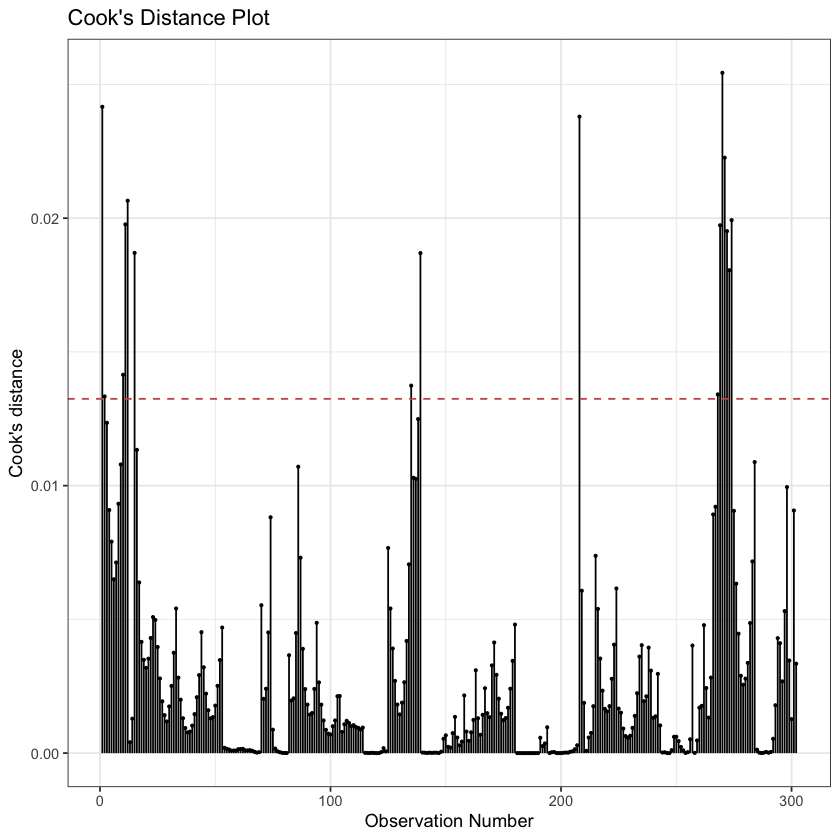

In [30]:
gg_cooksd(clean_model, label=FALSE) + theme_bw()

Looks much better for analysis! This works better because it does not have the extreme outliers in the data set. We can analyze this data better now. We will follow what we did earlier but with the clean data as the input and then create a data frame of the clean values to visualize better.

In [31]:
clean_model <- lm(value ~ createdAt, data = clean_data)
clean_cooks <- cooks.distance(clean_model)
clean_influential <- as.numeric(names(clean_cooks)[(clean_cooks > (4/nrow(temp)))])
clean_data$value[clean_influential] #Returns the temperature values in Celsius

[1] 28.67000 28.69000 28.72000 28.79000 28.70000 28.64258 29.62000 30.64000
 [9] 31.13000 31.54000 28.90000 28.90000 29.49000 30.21000 31.04000 31.95000
[17] 32.94000

In [32]:
influential_boxes <- data.frame(clean_data$sensorId[clean_influential], 
                                clean_data$value[clean_influential], 
                                clean_data$lat[clean_influential], 
                                clean_data$lon[clean_influential])
colnames(influential_boxes) <- (c("Sensor ID", "Temperature value(Celsius)", "Latitude", "Longitude"))
influential_boxes 

Sensor ID,Temperature value(Celsius),Latitude,Longitude
<fct>,<dbl>,<dbl>,<dbl>
56957f3ab3de1fe0052532e0,28.67000,51.95709,7.640643
56957f3ab3de1fe0052532e0,28.69000,51.95709,7.640643
56957f3ab3de1fe0052532e0,28.72000,51.95709,7.640643
56957f3ab3de1fe0052532e0,28.79000,51.95709,7.640643
56957f3ab3de1fe0052532e0,28.70000,51.95709,7.640643
5710de1a45fd40c8198cced4,28.64258,51.71017,7.542168
5a153fd319991f00113493a9,29.62000,51.95304,7.637048
5a153fd319991f00113493a9,30.64000,51.95304,7.637048
5a153fd319991f00113493a9,31.13000,51.95304,7.637048


Looks like these outliers are coming from the exact same boxes and are being consitently recorded through time! Maybe these boxes were set up incorrectly or have defects. We can now flag the ID's and notify the users of the problem or we can perform a further analysis to see if there is an environmental anomaly present where these boxes are located.

## Looking at other sensors

### Looking at the PM 2.5 sensors of boxes

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.2     1.0     1.3  1030.9     1.9 34548.0 

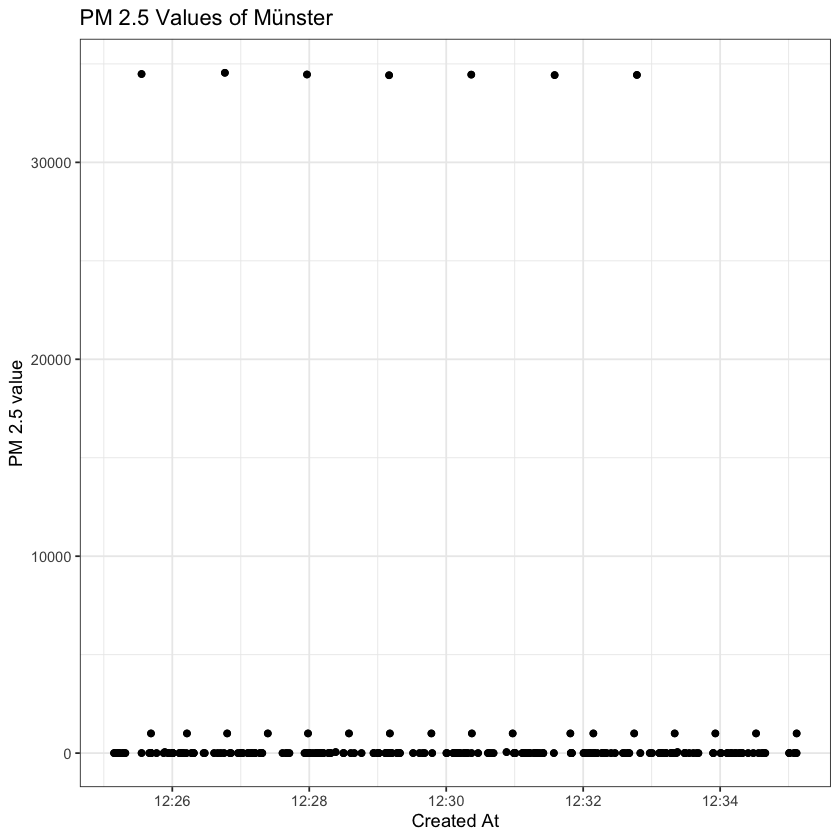

In [33]:
pm_25 <- osem_measurements(
    munster,
    phenomenon = 'PM2.5', #PM 2.5 Dust particulate sensor
    from = now() - minutes(10), #Münster PM_2.5 from 10 minutes ago to now
    to = now()
)
summary(pm_25$value) #Return a summary of the data

#Use ggplot2 library to plot data
ggplot(pm_25, aes(x=createdAt, y=value)) + 
    labs(x="Created At", y="PM 2.5 value") + 
    geom_point() + 
    geom_jitter(width = 0.15) +
    ggtitle("PM 2.5 Values of Münster") +
    theme_bw()

There appears to once again be very high outliers.

### Further analysis of the PM 2.5 values

In [34]:
pm_model <- lm(value ~ createdAt, data = pm_25) #First create a linear model of the data. This model is a time series of temperature.

pm_cooks <- cooks.distance(pm_model) #Next find the cook's distance

### Cook's distance of the PM 2.5 sensors model plot

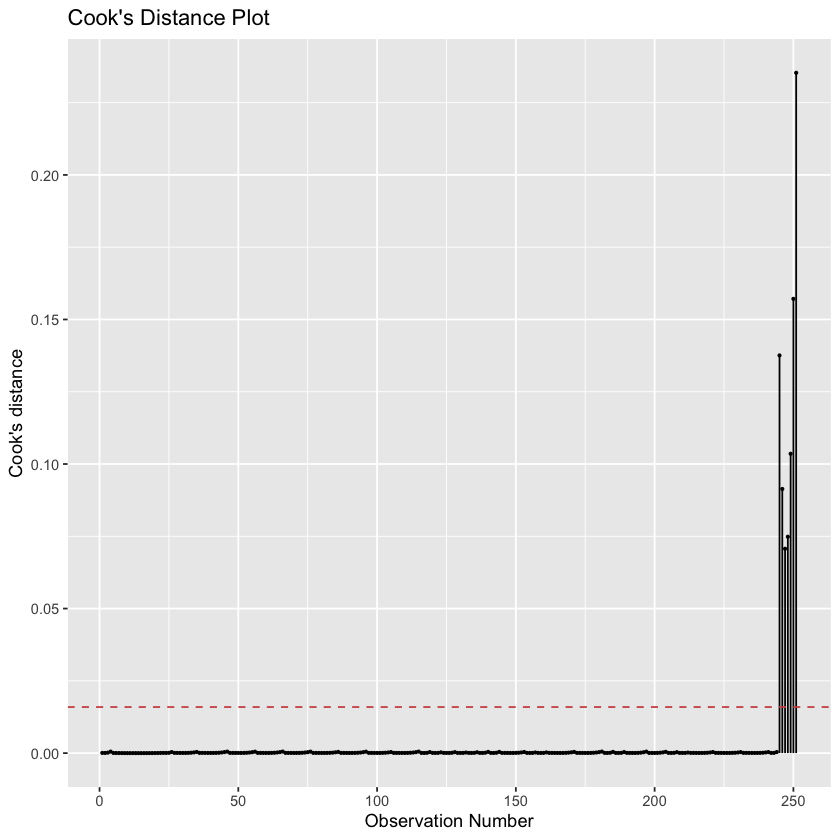

In [35]:
gg_cooksd(pm_model, label = FALSE) 

Any of these values that are above the dotted red line are influential points. We can find the exact SenseBoxes that correspond to these points

### Determing influential temperature values with cook's distance

In [36]:
pm_influential <- as.numeric(names(pm_cooks)[(pm_cooks > (4/nrow(temp)))])
pm_25$value[pm_influential] 

[1] 34439 34431 34455 34424 34462 34548 34486

### Getting the ID of defective boxes

In [37]:
#Create a data frame of the SenseBox ID's matched with their influential values and location
pm_influential_boxes <- data.frame(pm_25$sensorId[pm_influential], 
                                   pm_25$value[pm_influential], 
                                   pm_25$lat[pm_influential], 
                                   pm_25$lon[pm_influential])
colnames(pm_influential_boxes) <- (c("Sensor ID", "PM 2.5 Value", "Latitude", "Longitude"))
pm_influential_boxes 

Sensor ID,PM 2.5 Value,Latitude,Longitude
<fct>,<dbl>,<dbl>,<dbl>
5d18fec030bde6001ad8b2a6,34439,51.95496,7.627989
5d18fec030bde6001ad8b2a6,34431,51.95496,7.627989
5d18fec030bde6001ad8b2a6,34455,51.95496,7.627989
5d18fec030bde6001ad8b2a6,34424,51.95496,7.627989
5d18fec030bde6001ad8b2a6,34462,51.95496,7.627989
5d18fec030bde6001ad8b2a6,34548,51.95496,7.627989
5d18fec030bde6001ad8b2a6,34486,51.95496,7.627989


Once again, looks like these outliers are coming from the exact same boxes and are being consitently recorded through time.

### Cleaning the high outliers from the data frame and determining other influential values

In [38]:
influential_pm25 <- data.frame(value = pm_25$value[pm_influential])
#Clean pm25 data frame into a new data frame. Remove influential values and convert createdAt to time
clean_pm25 <- pm_25 %>%
    filter(!pm_25$value %in% influential_pm25$value) %>%
    mutate(createdAt = as.numeric(as.POSIXct(createdAt))) %>%
    select(value, createdAt, sensorId, lat, lon)

### Finding the cook's distances of the cleaned data frame

In [39]:
clean_model_pm25 <- lm(value ~ createdAt, data = clean_pm25)
clean_cooks_pm25 <- cooks.distance(clean_model_pm25)
clean_influential_pm25 <- as.numeric(names(clean_cooks_pm25)[(clean_cooks_pm25 > (4/nrow(pm_25)))])

### Plot Cook's distance of the cleaned data frame

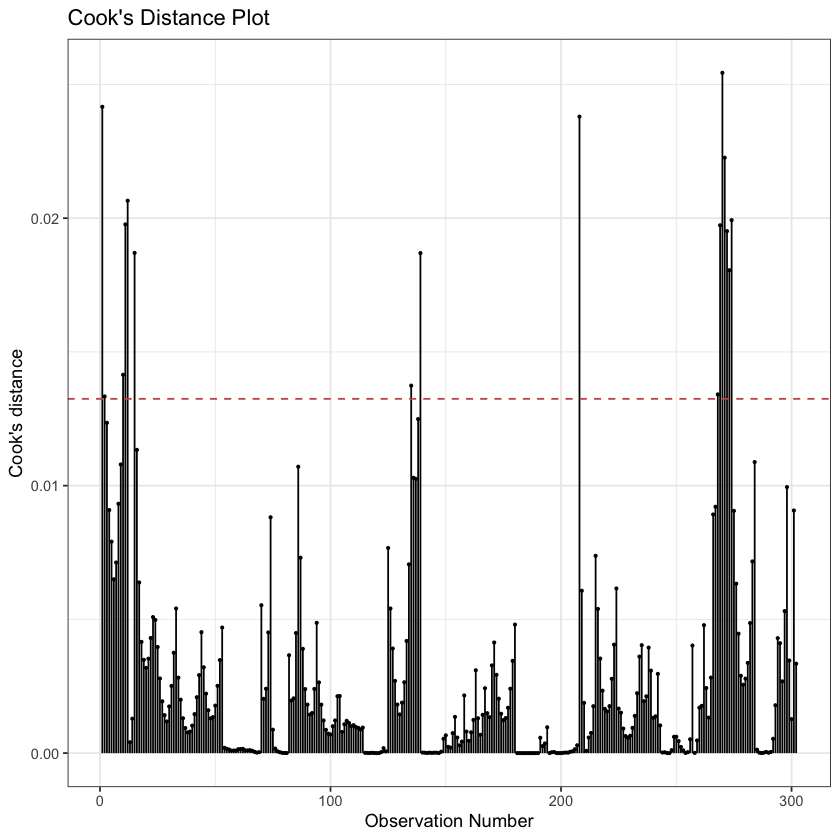

In [40]:
gg_cooksd(clean_model, label=FALSE) + theme_bw() 

### Influential values based off of cook's distance

In [41]:
clean_pm25$value[clean_influential_pm25]

[1] 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9
[13] 999.9 999.9 999.9 999.9 999.9

### Getting the ID of defective boxes

In [42]:
influential_boxes <- data.frame(clean_pm25$sensorId[clean_influential_pm25], 
                                clean_pm25$value[clean_influential_pm25], 
                                clean_pm25$lat[clean_influential_pm25], 
                                clean_pm25$lon[clean_influential_pm25])
colnames(influential_boxes) <- (c("Sensor ID", "PM 2.5 Value", "Lattitude", "Longitude"))
influential_boxes 

Sensor ID,PM 2.5 Value,Lattitude,Longitude
<fct>,<dbl>,<dbl>,<dbl>
59458624a4ad590011186665,999.9,51.96422,7.645218
59458624a4ad590011186665,999.9,51.96422,7.645218
59458624a4ad590011186665,999.9,51.96422,7.645218
59458624a4ad590011186665,999.9,51.96422,7.645218
59458624a4ad590011186665,999.9,51.96422,7.645218
59458624a4ad590011186665,999.9,51.96422,7.645218
59458624a4ad590011186665,999.9,51.96422,7.645218
59458624a4ad590011186665,999.9,51.96422,7.645218
59458624a4ad590011186665,999.9,51.96422,7.645218


Once again, the same box is consistently producing high outlier data. This implies that there must be a defect or user error.